# 数据挖掘作业四

## 姓名：林宁 学号：3220190838 

In [1]:
# 导入必要的包
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from time import *
import sys
import os

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.utils.utility import precision_n_scores
from pyod.utils.data import evaluate_print

from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length

import warnings
warnings.filterwarnings('ignore')

### 1. abalone_benchmarks:   
该数据集共有1725个benchmark，每个benchmark中包括1888条记录。

使用 [V1、V2、V3、V4、V5、V6、V7] 7种属性作为特征，ground.truth(nominal/anomaly)作为标签进行离群点分析与异常检测。

选取的方法依旧为：KNN / IForest / PCA / LOF / HBOS 。

####  1.1 读取数据

In [2]:
benchmark_path = []
benchmarks_path1 = "./abalone/benchmarks"
for files in os.listdir(benchmarks_path1):
    file_path = os.path.join(benchmarks_path1, files)
    benchmark_path.append(file_path)

print("Numbers of Benchmarks: ", len(benchmark_path))
data = pd.read_csv(benchmark_path[0])
print("the size of data:", data.shape)
data.head()

Numbers of Benchmarks:  1725
the size of data: (1888, 13)


,point.id,motherset,origin,original.label,diff.score,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1584,abalone,regression,7,0.153312,nominal,-0.116511,-0.129799,-0.227518,-0.461352,-0.353066,-0.342963,-0.551935
1,abalone_point_0315,abalone,regression,23,0.202253,anomaly,0.882716,0.777094,0.848341,0.960988,0.333986,1.039157,1.588828
2,abalone_point_1779,abalone,regression,8,0.562701,nominal,-0.283048,-0.532863,0.489721,0.103505,-0.048961,0.313886,0.313709
3,abalone_point_1926,abalone,regression,11,0.209155,anomaly,0.716178,0.625945,0.609261,0.713225,0.930932,0.893190,0.396322
4,abalone_point_0588,abalone,regression,13,0.163268,anomaly,0.216565,0.021350,0.131102,-0.000494,-0.224666,0.090375,0.080237


####  1.2 KNN

In [3]:
# KNN
ROC_mean = []
PRN_mean = []
time_c_total = []

begin_time = time()
knn_roc = []
knn_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["V1","V2","V3","V4","V5","V6","V7"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = KNN(n_neighbors = 5) 
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    knn_roc.append(roc_)
    knn_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('KNN', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('KNN', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(knn_roc))
PRN_mean.append(np.mean(knn_prn))
time_c_total.append(run_time)

Iter 0
Training data:
KNN ROC:0.7676, precision @ rank n:0.6881
Test Data:
KNN ROC:0.7545, precision @ rank n:0.6703
Iter 200
Training data:
KNN ROC:0.7224, precision @ rank n:0.6474
Test Data:
KNN ROC:0.7254, precision @ rank n:0.6409
Iter 1000
Training data:
KNN ROC:0.8406, precision @ rank n:0.1333
Test Data:
KNN ROC:0.8573, precision @ rank n:0.0
Iter 1200
Training data:
KNN ROC:0.9994, precision @ rank n:0.9333
Test Data:
KNN ROC:1.0, precision @ rank n:1.0
Iter 1400
Training data:
KNN ROC:0.271, precision @ rank n:0.0625
Test Data:
KNN ROC:0.3514, precision @ rank n:0.1538
Iter 1600
Training data:
KNN ROC:0.8129, precision @ rank n:0.3742
Test Data:
KNN ROC:0.8905, precision @ rank n:0.4468


#### 1.3 IForest 

In [4]:
# IForest
begin_time = time()
if_roc = []
if_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["V1","V2","V3","V4","V5","V6","V7"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = IForest(n_estimators = 100)  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if_roc.append(roc_)
    if_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('IForest', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('IForest', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(if_roc))
PRN_mean.append(np.mean(if_prn))
time_c_total.append(run_time)

Iter 0
Training data:
IForest ROC:0.4825, precision @ rank n:0.4698
Test Data:
IForest ROC:0.4579, precision @ rank n:0.4541
Iter 200
Training data:
IForest ROC:0.5011, precision @ rank n:0.466
Test Data:
IForest ROC:0.5132, precision @ rank n:0.4503
Iter 1000
Training data:
IForest ROC:0.7681, precision @ rank n:0.1333
Test Data:
IForest ROC:0.766, precision @ rank n:0.0
Iter 1200
Training data:
IForest ROC:0.981, precision @ rank n:0.7073
Test Data:
IForest ROC:0.989, precision @ rank n:0.8333
Iter 1400
Training data:
IForest ROC:0.5007, precision @ rank n:0.0625
Test Data:
IForest ROC:0.4108, precision @ rank n:0.1538
Iter 1600
Training data:
IForest ROC:0.7154, precision @ rank n:0.284
Test Data:
IForest ROC:0.7059, precision @ rank n:0.2917


#### 1.4 PCA 

In [5]:
# PCA
begin_time = time()
pca_roc = []
pca_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["V1","V2","V3","V4","V5","V6","V7"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = PCA()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    pca_roc.append(roc_)
    pca_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('PCA', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('PCA', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(pca_roc))
PRN_mean.append(np.mean(pca_prn))
time_c_total.append(run_time)

Iter 0
Training data:
PCA ROC:0.4823, precision @ rank n:0.4694
Test Data:
PCA ROC:0.5368, precision @ rank n:0.5181
Iter 200
Training data:
PCA ROC:0.5058, precision @ rank n:0.4863
Test Data:
PCA ROC:0.4925, precision @ rank n:0.4576
Iter 1000
Training data:
PCA ROC:0.7438, precision @ rank n:0.0
Test Data:
PCA ROC:0.5851, precision @ rank n:0.4
Iter 1200
Training data:
PCA ROC:0.9689, precision @ rank n:0.7027
Test Data:
PCA ROC:0.9775, precision @ rank n:0.7
Iter 1400
Training data:
PCA ROC:0.5411, precision @ rank n:0.0755
Test Data:
PCA ROC:0.7601, precision @ rank n:0.125
Iter 1600
Training data:
PCA ROC:0.6547, precision @ rank n:0.25
Test Data:
PCA ROC:0.7934, precision @ rank n:0.5


#### 1.5 LOF 

In [6]:
# LOF
begin_time = time()
lof_roc = []
lof_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["V1","V2","V3","V4","V5","V6","V7"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = LOF()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    lof_roc.append(roc_)
    lof_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('LOF', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('LOF', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(lof_roc))
PRN_mean.append(np.mean(lof_prn))
time_c_total.append(run_time)

Iter 0
Training data:
LOF ROC:0.5846, precision @ rank n:0.5524
Test Data:
LOF ROC:0.5958, precision @ rank n:0.5562
Iter 200
Training data:
LOF ROC:0.5673, precision @ rank n:0.5406
Test Data:
LOF ROC:0.5898, precision @ rank n:0.5611
Iter 1200
Training data:
LOF ROC:0.8568, precision @ rank n:0.4615
Test Data:
LOF ROC:0.9194, precision @ rank n:0.375
Iter 1400
Training data:
LOF ROC:0.3366, precision @ rank n:0.02
Test Data:
LOF ROC:0.3987, precision @ rank n:0.0909
Iter 1600
Training data:
LOF ROC:0.6673, precision @ rank n:0.2281
Test Data:
LOF ROC:0.6417, precision @ rank n:0.1538


#### 1.6 HBOS

In [7]:
# HBOS
begin_time = time()
hbos_roc = []
hbos_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["V1","V2","V3","V4","V5","V6","V7"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = HBOS()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    hbos_roc.append(roc_)
    hbos_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('HBOS', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('HBOS', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(hbos_roc))
PRN_mean.append(np.mean(hbos_prn))
time_c_total.append(run_time)

Iter 0
Training data:
HBOS ROC:0.4806, precision @ rank n:0.4369
Test Data:
HBOS ROC:0.5205, precision @ rank n:0.526
Iter 200
Training data:
HBOS ROC:0.5082, precision @ rank n:0.462
Test Data:
HBOS ROC:0.5466, precision @ rank n:0.5728
Iter 1200
Training data:
HBOS ROC:0.9844, precision @ rank n:0.6923
Test Data:
HBOS ROC:0.9931, precision @ rank n:0.875
Iter 1400
Training data:
HBOS ROC:0.616, precision @ rank n:0.0698
Test Data:
HBOS ROC:0.537, precision @ rank n:0.0
Iter 1600
Training data:
HBOS ROC:0.7775, precision @ rank n:0.3782
Test Data:
HBOS ROC:0.7227, precision @ rank n:0.4082


#### 1.7 对比 

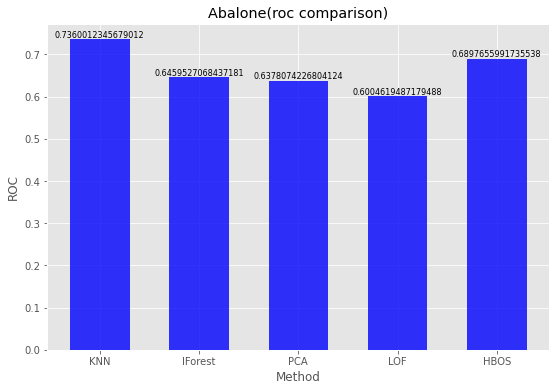

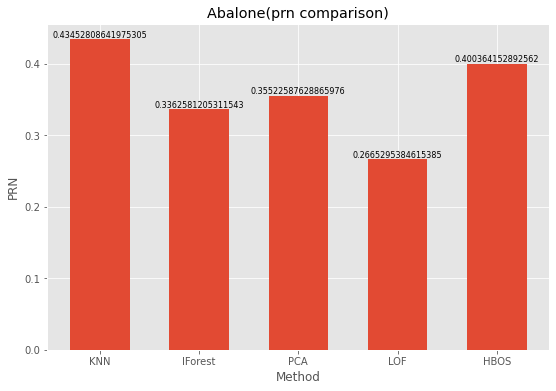

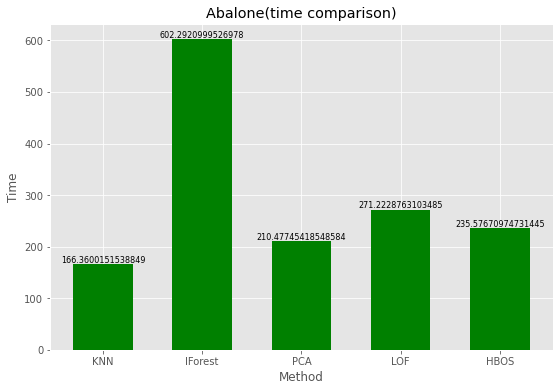

In [8]:
plt.style.use('ggplot')
name = ["KNN", "IForest", "PCA", "LOF", "HBOS"]

#roc对比
plt.figure(figsize=(9,6))
plt.bar(name, ROC_mean ,color='blue',width=0.6,alpha=0.8)
for x, y in zip(name, ROC_mean):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("ROC")
plt.title("Abalone(roc comparison)")
plt.show()

#prn对比
plt.figure(figsize=(9,6))
plt.bar(name, PRN_mean ,width=0.6)
for x, y in zip(name, PRN_mean):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("PRN")
plt.title("Abalone(prn comparison)")
plt.show()

#时间对比
plt.figure(figsize=(9,6))
plt.bar(name, time_c_total,color='green' ,width=0.6)
for x, y in zip(name, time_c_total):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("Time")
plt.title("Abalone(time comparison)")
plt.show()

从对比结果看出，在abalone数据集上，KNN的表现结果最好，其次是HBOS。

### 2. skin_benchmarks:

该数据集共有1500个benchmark，每个benchmark中包括6000条记录。

使用 [R、G、B] 3种属性作为特征，ground.truth(nominal/anomaly)作为标签进行离群点分析与异常检测。

选取的方法依旧为：KNN / IForest / PCA / LOF / HBOS 。

#### 2.1 读取数据 

In [9]:
benchmark_path = []
benchmarks_path1 = "./skin/benchmarks"
for files in os.listdir(benchmarks_path1):
    file_path = os.path.join(benchmarks_path1, files)
    benchmark_path.append(file_path)

print("Numbers of Benchmarks: ", len(benchmark_path))
data = pd.read_csv(benchmark_path[0])
print("the size of data:", data.shape)
data.head()

Numbers of Benchmarks:  1500
the size of data: (6000, 9)


,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


#### 2.2 KNN

In [10]:
# KNN
ROC_mean = []
PRN_mean = []
time_c_total = []

begin_time = time()
knn_roc = []
knn_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["R","G","B"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = KNN(n_neighbors = 5) 
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    knn_roc.append(roc_)
    knn_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('KNN', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('KNN', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(knn_roc))
PRN_mean.append(np.mean(knn_prn))
time_c_total.append(run_time)

Iter 0
Training data:
KNN ROC:0.7089, precision @ rank n:0.2407
Test Data:
KNN ROC:0.7297, precision @ rank n:0.2054
Iter 200
Training data:
KNN ROC:0.1906, precision @ rank n:0.0634
Test Data:
KNN ROC:0.1708, precision @ rank n:0.0604
Iter 600
Training data:
KNN ROC:0.9683, precision @ rank n:0.0
Test Data:
KNN ROC:0.9642, precision @ rank n:0.0
Iter 800
Training data:
KNN ROC:0.9111, precision @ rank n:0.0213
Test Data:
KNN ROC:0.9326, precision @ rank n:0.0769
Iter 1000
Training data:
KNN ROC:0.9523, precision @ rank n:0.1522
Test Data:
KNN ROC:0.9574, precision @ rank n:0.2143
Iter 1200
Training data:
KNN ROC:0.7043, precision @ rank n:0.0369
Test Data:
KNN ROC:0.6529, precision @ rank n:0.0357
Iter 1400
Training data:
KNN ROC:0.5456, precision @ rank n:0.042
Test Data:
KNN ROC:0.5774, precision @ rank n:0.0806


#### 2.3 IForest

In [11]:
# IForest
begin_time = time()
if_roc = []
if_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["R","G","B"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = IForest(n_estimators = 100)  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if_roc.append(roc_)
    if_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('IForest', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('IForest', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(if_roc))
PRN_mean.append(np.mean(if_prn))
time_c_total.append(run_time)

Iter 0
Training data:
IForest ROC:0.6906, precision @ rank n:0.1861
Test Data:
IForest ROC:0.7126, precision @ rank n:0.232
Iter 200
Training data:
IForest ROC:0.4416, precision @ rank n:0.0392
Test Data:
IForest ROC:0.4537, precision @ rank n:0.041
Iter 600
Training data:
IForest ROC:0.8921, precision @ rank n:0.0
Test Data:
IForest ROC:0.9016, precision @ rank n:0.0
Iter 800
Training data:
IForest ROC:0.9448, precision @ rank n:0.0
Test Data:
IForest ROC:0.9287, precision @ rank n:0.0
Iter 1000
Training data:
IForest ROC:0.4865, precision @ rank n:0.0
Test Data:
IForest ROC:0.5397, precision @ rank n:0.0
Iter 1200
Training data:
IForest ROC:0.5042, precision @ rank n:0.0
Test Data:
IForest ROC:0.4927, precision @ rank n:0.0
Iter 1400
Training data:
IForest ROC:0.7033, precision @ rank n:0.0063
Test Data:
IForest ROC:0.7293, precision @ rank n:0.008


#### 2.4 PCA 

In [12]:
# PCA
begin_time = time()
pca_roc = []
pca_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["R","G","B"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = PCA()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    pca_roc.append(roc_)
    pca_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('PCA', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('PCA', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(pca_roc))
PRN_mean.append(np.mean(pca_prn))
time_c_total.append(run_time)

Iter 0
Training data:
PCA ROC:0.4497, precision @ rank n:0.0359
Test Data:
PCA ROC:0.4501, precision @ rank n:0.0373
Iter 200
Training data:
PCA ROC:0.5492, precision @ rank n:0.2173
Test Data:
PCA ROC:0.5224, precision @ rank n:0.18
Iter 600
Training data:
PCA ROC:0.6183, precision @ rank n:0.0
Test Data:
PCA ROC:0.808, precision @ rank n:0.0
Iter 800
Training data:
PCA ROC:0.5549, precision @ rank n:0.2264
Test Data:
PCA ROC:0.6482, precision @ rank n:0.0
Iter 1000
Training data:
PCA ROC:0.2209, precision @ rank n:0.0
Test Data:
PCA ROC:0.2777, precision @ rank n:0.0
Iter 1200
Training data:
PCA ROC:0.1981, precision @ rank n:0.0
Test Data:
PCA ROC:0.2296, precision @ rank n:0.0
Iter 1400
Training data:
PCA ROC:0.6402, precision @ rank n:0.1035
Test Data:
PCA ROC:0.666, precision @ rank n:0.1207


#### 2.5 LOF

In [13]:
# LOF
begin_time = time()
lof_roc = []
lof_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["R","G","B"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = LOF()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    lof_roc.append(roc_)
    lof_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('LOF', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('LOF', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(lof_roc))
PRN_mean.append(np.mean(lof_prn))
time_c_total.append(run_time)

Iter 0
Training data:
LOF ROC:0.4396, precision @ rank n:0.1191
Test Data:
LOF ROC:0.4182, precision @ rank n:0.0782
Iter 200
Training data:
LOF ROC:0.5042, precision @ rank n:0.1945
Test Data:
LOF ROC:0.5038, precision @ rank n:0.2172
Iter 800
Training data:
LOF ROC:0.5434, precision @ rank n:0.0
Test Data:
LOF ROC:0.2824, precision @ rank n:0.0
Iter 1000
Training data:
LOF ROC:0.7799, precision @ rank n:0.0
Test Data:
LOF ROC:0.8522, precision @ rank n:0.0
Iter 1200
Training data:
LOF ROC:0.4897, precision @ rank n:0.0
Test Data:
LOF ROC:0.4922, precision @ rank n:0.0156
Iter 1400
Training data:
LOF ROC:0.4621, precision @ rank n:0.0556
Test Data:
LOF ROC:0.4672, precision @ rank n:0.0351


#### 2.6 HBOS 

In [14]:
# HBOS
begin_time = time()
hbos_roc = []
hbos_prn =[]
for i in range(len(benchmark_path)):
    data = pd.read_csv(benchmark_path[i])
    
    X = data[["R","G","B"]].values
    Y = np.where(data["ground.truth"] == "nominal" , 0 ,1)
    X,Y = shuffle(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    if np.sum(Y_test) < 5:
        continue
        
    clf = HBOS()  
    clf.fit(X_train) 
    
    Y_train_pred = clf.labels_ 
    Y_train_scores = clf.decision_scores_
    Y_test_pred = clf.predict(X_test) 
    Y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(Y_test_scores)
    check_consistent_length(y, y_pred)
    
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    hbos_roc.append(roc_)
    hbos_prn.append(prn_)
    
    if i % 200 == 0:
        print("Iter "+str(i))
        print("Training data:")
        evaluate_print('HBOS', Y_train, Y_train_scores)
         
        print("Test Data:")
        evaluate_print('HBOS', Y_test, Y_test_scores)
    
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(hbos_roc))
PRN_mean.append(np.mean(hbos_prn))
time_c_total.append(run_time)

Iter 0
Training data:
HBOS ROC:0.6003, precision @ rank n:0.2216
Test Data:
HBOS ROC:0.6097, precision @ rank n:0.1844
Iter 200
Training data:
HBOS ROC:0.3144, precision @ rank n:0.1121
Test Data:
HBOS ROC:0.2543, precision @ rank n:0.1065
Iter 600
Training data:
HBOS ROC:0.7985, precision @ rank n:0.0
Test Data:
HBOS ROC:0.6537, precision @ rank n:0.0
Iter 800
Training data:
HBOS ROC:0.7666, precision @ rank n:0.0638
Test Data:
HBOS ROC:0.8364, precision @ rank n:0.1
Iter 1000
Training data:
HBOS ROC:0.4529, precision @ rank n:0.0
Test Data:
HBOS ROC:0.4141, precision @ rank n:0.0
Iter 1200
Training data:
HBOS ROC:0.4229, precision @ rank n:0.0
Test Data:
HBOS ROC:0.3803, precision @ rank n:0.0
Iter 1400
Training data:
HBOS ROC:0.4794, precision @ rank n:0.0356
Test Data:
HBOS ROC:0.5258, precision @ rank n:0.0513


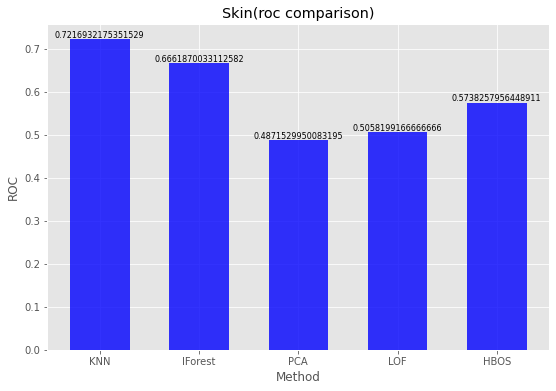

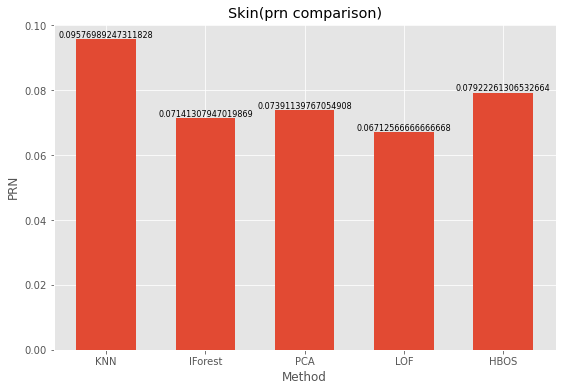

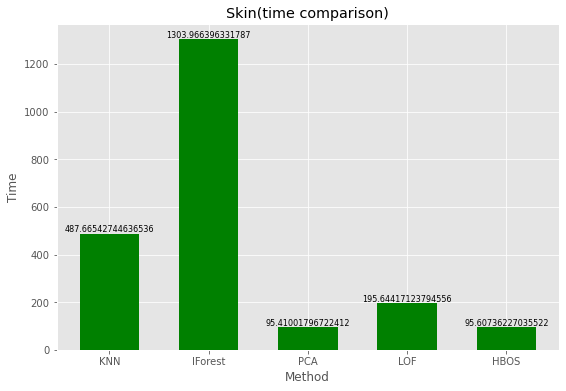

In [15]:
plt.style.use('ggplot')
name = ["KNN", "IForest", "PCA", "LOF", "HBOS"]

#roc对比
plt.figure(figsize=(9,6))
plt.bar(name, ROC_mean ,color='blue',width=0.6,alpha=0.8)
for x, y in zip(name, ROC_mean):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("ROC")
plt.title("Skin(roc comparison)")
plt.show()

#prn对比
plt.figure(figsize=(9,6))
plt.bar(name, PRN_mean ,width=0.6)
for x, y in zip(name, PRN_mean):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("PRN")
plt.title("Skin(prn comparison)")
plt.show()

#时间对比
plt.figure(figsize=(9,6))
plt.bar(name, time_c_total,color='green' ,width=0.6)
for x, y in zip(name, time_c_total):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xlabel("Method")
plt.ylabel("Time")
plt.title("Skin(time comparison)")
plt.show()

从对比结果看出，在skin数据集上，KNN的表现结果最好，其次是IForest，其消耗时间也比其他三个长。而PCA和LOF的性能不是很好，可能的原因是他们都适用于高维数据，而Skin数据集只有三维数据，所以效果不是很好。